In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8000),
    tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8000)])

logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

logical_gpus  

tf.config.set_soft_device_placement(False)
tf.debugging.set_log_device_placement(True)
import numpy as np
from ampligraph.datasets import load_fb15k_237

from ampligraph.evaluation.metrics import mrr_score, hits_at_n_score
import time

from ampligraph.datasets import GraphDataLoader, BucketGraphPartitioner, RandomVerticesGraphPartitioner, RandomEdgesGraphPartitioner,\
SortedEdgesGraphPartitioner, DoubleSortedEdgesGraphPartitioner, NaiveGraphPartitioner
from ampligraph.datasets.graph_partitioner import PARTITION_ALGO_REGISTRY
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.datasets import DataIndexer, GraphDataLoader, SQLiteAdapter, load_fb15k_237
import pandas as pd
import shelve

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPU, 2 Logical GPUs


## New Pipeline: Data Loading & Partitioning - Example Usage Scenarios

This Notebook walks you through new unified data loading pipeline, that extends previous capabilities by providing support for partitioning of graphs and possibility to use database backend.

Pros:
- Unified data interface.
- Support for large graphs (backend, partitioning).
- Support for partitioning of input graphs.
- Modular design that is easily extendable.
- Support for SQLite backend (optional).
- Customization support.

### Summary:

1. [Loading Data](#loading_data)
    - [Indexing data.](#indexing)
    - [Loading data from numpy array.](#numpy_array)
    - [Loading data from csv file.](#csv_file)
    - [Loading data using different backends:](#backends)
        - [in-memory - DummyBackend [by default].](#dummy)
        - [in the database - SQLiteAdapter [database].](#sqlite)
    - [Custom file format support.](#custom_format)
        - [DataSourceIdentifier](#source_identifier)
    - [DataIndexer](#data_indexer)
2. [Accessing Data](#access_data)
3. [Partitioning Data](#partitioning)
    - [Different partitionings startegies:](#partitioning)
        - [Bucket](#bucket)
        - [Random Vertices](#random_vertices)
        - [Random Edges](#random_edges)
        - [Sorted Edges](#sorted_edges)
        - [Naive](#naive)
        - [Double Sorted Edges](#double_sorted)
    - [Comparison of partitionings (Partitioning Reporter).](#comparison)
    - [Accessing original data through partition](#partition_data)
        - [Recovering original raw data from partition.](#recover)

<a id='loading_data'></a>
### Loading Data (and recovering raw data)

GraphDataLoader is used to handle data loading, it can accept as input files (csv, txt) and numpy array, it is also possible to extend the loader to provide support for different file types through `DataSourceIdentifier`.

GraphDataLoader is a generator with data that you can use later in the loop like that: 
```
for batch in data: 
    process(batch)
```
where every batch is a numpy array. It can be used for in-memory processing (DummyBackend) or using a database backend (SQLiteAdapter). 

`data = GraphDataLoader("./train.csv", batch_size=4)`. 

GraphDataLoader proivides next batch and get complementary/participating entities for given triples (subjects/objects/both), these functions are exposed to the user in the interface of GraphDataLoader, while the implementation details are hidden in the backend.

<a id='indexing'></a>
#### Indexing Data
Data when loading is reindexed using DataIndexer class created internally - entities (subjects, objects) are indexed (0, &lt;UNIQUE ENTITIES SIZE&gt;), and adequatly relations (predicates) are indexed (0, &lt;UNIQUE RELATIONS SIZE&gt;). More about data indexing in section [DataIndexer](#data_indexer).

Mapping creation/indexing is provided through either in-memory dictionary or python native dictionary-like persistence storage `shelves` lifting the need for storing whole dictionary in-memory while operating on the data.

<a id='numpy_array'></a>
#### From numpy array:

In [2]:
raw_data = np.array([[1,1,2], [1,1,3],[1,1,4],[5,1,3],[5,1,2],[6,1,3],[6,1,2],[6,1,4],[6,1,7]])
data = GraphDataLoader(raw_data, batch_size=1, dataset_type="test")
for batch in data:
    print("Indexed data: {:>10}]".format("["+", ".join(str(x) for x in batch[0])))
    ents = data.backend.mapper.entities_dict
    rels = data.backend.mapper.relations_dict    
    print("Original data: ", [ents[batch[0][0]], rels[batch[0][1]], ents[batch[0][2]]])    

Indexed data:   [0, 0, 1]
Original data:  [1, 1, 2]
Indexed data:   [0, 0, 2]
Original data:  [1, 1, 3]
Indexed data:   [0, 0, 3]
Original data:  [1, 1, 4]
Indexed data:   [4, 0, 2]
Original data:  [5, 1, 3]
Indexed data:   [4, 0, 1]
Original data:  [5, 1, 2]
Indexed data:   [5, 0, 2]
Original data:  [6, 1, 3]
Indexed data:   [5, 0, 1]
Original data:  [6, 1, 2]
Indexed data:   [5, 0, 3]
Original data:  [6, 1, 4]
Indexed data:   [5, 0, 6]
Original data:  [6, 1, 7]


<a id='csv_file'></a>
#### From csv file:

In [5]:
data_file = "./fb15k/test.txt"
data = GraphDataLoader(data_file, batch_size=2, dataset_type="test")
for batch in data:
    print("Indexed: ", batch[0])
    ents = data.backend.mapper.entities_dict
    rels = data.backend.mapper.relations_dict    
    print("Original data: ", [ents[batch[0][0]], rels[batch[0][1]], ents[batch[0][2]]])      

Indexed:  [0 0 1]
Original data:  ['/m/01qscs', '/award/award_nominee/award_nominations./award/award_nomination/award', '/m/02x8n1n']
Indexed:  [4 2 5]
Original data:  ['/m/08966', '/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month', '/m/05lf_']
Indexed:  [8 0 9]
Original data:  ['/m/0c1pj', '/award/award_nominee/award_nominations./award/award_nomination/award', '/m/019f4v']
Indexed:  [12  5 13]
Original data:  ['/m/09v3jyg', '/film/film/release_date_s./film/film_regional_release_date/film_release_region', '/m/0f8l9c']
Indexed:  [14  6 16]
Original data:  ['/m/02jx1', '/location/location/contains', '/m/0m0bj']
Indexed:  [19  8 20]
Original data:  ['/m/05zrvfd', '/award/award_category/nominees./award/award_nomination/nominated_for', '/m/04y9mm8']
Indexed:  [23 10 24]
Original data:  ['/m/060bp', '/government/government_office_category/officeholders./government/government_position_held/jurisdiction_of_office', '/m/04j53']
Indexed:  [26 12 27]
Original da

Indexed:  [1840  227 1655]
Original data:  ['/m/081pw', '/film/film_subject/films', '/m/05cvgl']
Indexed:  [1841  298 1843]
Original data:  ['/m/0184jw', '/film/producer/film', '/m/011yqc']
Indexed:  [1844  299   61]
Original data:  ['/m/06q07', '/business/business_operation/operating_income./measurement_unit/dated_money_value/currency', '/m/09nqf']
Indexed:  [1846  161   22]
Original data:  ['/m/03d0d7', '/sports/sports_team/roster./soccer/football_roster_position/position', '/m/0dgrmp']
Indexed:  [1849  175  653]
Original data:  ['/m/01njml', '/soccer/football_team/current_roster./sports/sports_team_roster/position', '/m/02nzb8']
Indexed:  [428 216  45]
Original data:  ['/m/01_0f7', '/film/film/country', '/m/07ssc']
Indexed:  [1853  301  211]
Original data:  ['/m/07gknc', '/film/actor/dubbing_performances./film/dubbing_performance/language', '/m/02h40lc']
Indexed:  [1856  137 1857]
Original data:  ['/m/0nbcg', '/people/profession/people_with_this_profession', '/m/020hyj']
Indexed:  [

Original data:  ['/m/0nvg4', '/location/statistical_region/rent50_4./measurement_unit/dated_money_value/currency', '/m/09nqf']
Indexed:  [3274   12 1033]
Original data:  ['/m/0gnjh', '/film/film/genre', '/m/02l7c8']
Indexed:  [3275    0 1753]
Original data:  ['/m/0b05xm', '/award/award_nominee/award_nominations./award/award_nomination/award', '/m/0fbtbt']
Indexed:  [1810   56 1836]
Original data:  ['/m/01jc6q', '/award/award_nominated_work/award_nominations./award/award_nomination/award', '/m/040njc']
Indexed:  [3277   15 3278]
Original data:  ['/m/0f6_dy', '/award/award_nominee/award_nominations./award/award_nomination/award_nominee', '/m/05wqr1']
Indexed:  [3281  175  297]
Original data:  ['/m/033g0y', '/soccer/football_team/current_roster./sports/sports_team_roster/position', '/m/02sdk9v']
Indexed:  [3284   93 3285]
Original data:  ['/m/0b2lw', '/location/location/people_born_here', '/m/0436zq']
Indexed:  [3287  154 3288]
Original data:  ['/m/0flsf', '/location/capital_of_administra

Original data:  ['/m/044mfr', '/music/artist/genre', '/m/05bt6j']
Indexed:  [470 123 208]
Original data:  ['/m/0345h', '/olympics/olympic_participating_country/athletes./olympics/olympic_athlete_affiliation/olympics', '/m/0lbbj']
Indexed:  [ 470   51 2425]
Original data:  ['/m/0345h', '/organization/organization_member/member_of./organization/organization_membership/organization', '/m/02jxk']
Indexed:  [1374  110 4500]
Original data:  ['/m/06ncr', '/music/performance_role/track_performances./music/track_contribution/role', '/m/05kms']
Indexed:  [4502   49 4503]
Original data:  ['/m/09kr66', '/people/ethnicity/people', '/m/027l0b']
Indexed:  [2498   15 4505]
Original data:  ['/m/08s_lw', '/award/award_nominee/award_nominations./award/award_nomination/award_nominee', '/m/04myfb7']
Indexed:  [4507   71 2102]
Original data:  ['/m/0blpg', '/film/film/distributors./film/film_film_distributor_relationship/distributor', '/m/0jz9f']
Indexed:  [4508   35 4509]
Original data:  ['/m/08849', '/peop

Original data:  ['/m/07w21', '/influence/influence_node/influenced', '/m/0p8jf']
Indexed:  [5513  242 1110]
Original data:  ['/m/01kcmr', '/organization/organization/leadership./organization/leadership/role', '/m/0dq_5']
Indexed:  [5514   76 2147]
Original data:  ['/m/0cqhmg', '/award/award_category/winners./award/award_honor/award_winner', '/m/01dw4q']
Indexed:  [1747   56    1]
Original data:  ['/m/0gxtknx', '/award/award_nominated_work/award_nominations./award/award_nomination/award', '/m/02x8n1n']
Indexed:  [1753   76 5517]
Original data:  ['/m/0fbtbt', '/award/award_category/winners./award/award_honor/award_winner', '/m/056wb']
Indexed:  [ 472    8 2799]
Original data:  ['/m/018wdw', '/award/award_category/nominees./award/award_nomination/nominated_for', '/m/0pb33']
Indexed:  [4591   20 5518]
Original data:  ['/m/0l34j', '/location/location/containedby', '/m/06pvr']
Indexed:  [3168    7 5519]
Original data:  ['/m/030hcs', '/film/actor/film./film/performance/film', '/m/0g3zrd']
Ind

Indexed:  [6407   56  356]
Original data:  ['/m/0g9wdmc', '/award/award_nominated_work/award_nominations./award/award_nomination/award', '/m/027dtxw']
Indexed:  [6408   88  458]
Original data:  ['/m/0837ql', '/people/person/spouse_s./people/marriage/type_of_union', '/m/04ztj']
Indexed:  [1654  158 4310]
Original data:  ['/m/05b4w', '/olympics/olympic_participating_country/athletes./olympics/olympic_athlete_affiliation/sport', '/m/0d1t3']
Indexed:  [6411   94 2668]
Original data:  ['/m/06h2w', '/award/award_winner/awards_won./award/award_honor/award_winner', '/m/01qdjm']
Indexed:  [768 113 563]
Original data:  ['/m/01f2q5', '/music/artist/genre', '/m/016clz']
Indexed:  [6412  307  383]
Original data:  ['/m/0b_6s7', '/time/event/locations', '/m/013yq']
Indexed:  [ 774   42 6413]
Original data:  ['/m/017s11', '/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film', '/m/04t6fk']
Indexed:  [6414   15 6415]
Original data:  ['/m/03w9sgh', '/award/award_nominee

Indexed:  [6008   49  138]
Original data:  ['/m/018s6c', '/people/ethnicity/people', '/m/0g_rs_']
Indexed:  [7201  176  194]
Original data:  ['/m/04d_mtq', '/base/popstra/celebrity/vacations_in./base/popstra/vacation_choice/location', '/m/05qtj']
Indexed:  [2570  142 1001]
Original data:  ['/m/01f1r4', '/education/educational_institution/students_graduates./education/education/degree', '/m/0bkj86']
Indexed:  [ 880   42 7202]
Original data:  ['/m/05qd_', '/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film', '/m/07g_0c']
Indexed:  [4522   54 5120]
Original data:  ['/m/09k56b7', '/film/film/executive_produced_by', '/m/02rchht']
Indexed:  [3991    5 2925]
Original data:  ['/m/04nm0n0', '/film/film/release_date_s./film/film_regional_release_date/film_release_region', '/m/03gj2']
Indexed:  [2580   40 2190]
Original data:  ['/m/01r2c7', '/people/person/profession', '/m/02jknp']
Indexed:  [698  15 727]
Original data:  ['/m/0277470', '/award/award_nominee/awa

Indexed:  [7529  137 2571]
Original data:  ['/m/047rgpy', '/people/profession/people_with_this_profession', '/m/01trhmt']
Indexed:  [ 837   69 7530]
Original data:  ['/m/01jfsb', '/film/film_genre/films_in_this_genre', '/m/015bpl']
Indexed:  [6438  181 2089]
Original data:  ['/m/0hwqz', '/base/popstra/celebrity/dated./base/popstra/dated/participant', '/m/02x2t07']
Indexed:  [ 844   76 2325]
Original data:  ['/m/01by1l', '/award/award_category/winners./award/award_honor/award_winner', '/m/0g10g']
Indexed:  [4974  599  855]
Original data:  ['/m/0bx_q', '/food/diet_follower/follows_diet', '/m/07_lq']
Indexed:  [ 956    0 4152]
Original data:  ['/m/0169dl', '/award/award_nominee/award_nominations./award/award_nomination/award', '/m/099tbz']
Indexed:  [ 859   35 7532]
Original data:  ['/m/090gpr', '/people/person/place_of_birth', '/m/09c17']
Indexed:  [3651   15  883]
Original data:  ['/m/0b68vs', '/award/award_nominee/award_nominations./award/award_nomination/award_nominee', '/m/045zr']
In

Indexed:  [  72  115 3901]
Original data:  ['/m/0d060g', '/olympics/olympic_participating_country/medals_won./olympics/olympic_medal_honor/olympics', '/m/01f1jy']
Indexed:  [8075  421 8079]
Original data:  ['/m/04pzy', '/film/film_character/portrayed_in_films./film/performance/film', '/m/01_mdl']
Indexed:  [7161  283 1648]
Original data:  ['/m/03mgx6z', '/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium', '/m/029j_']
Indexed:  [7571   12 1682]
Original data:  ['/m/017kz7', '/film/film/genre', '/m/04t36']
Indexed:  [8083   34 3782]
Original data:  ['/m/01dvtx', '/influence/influence_node/influenced_by', '/m/02wh0']
Indexed:  [6867  280 4826]
Original data:  ['/m/063ykwt', '/tv/tv_program/tv_producer./tv/tv_producer_term/producer', '/m/02tn0_']
Indexed:  [4642    0  185]
Original data:  ['/m/03s9b', '/award/award_nominee/award_nominations./award/award_nomination/award', '/m/0gr51']
Indexed:  [2642  317 8084]
Original data:  ['/m/04k4rt', '/award/

Original data:  ['/m/0fpv_3_', '/film/film/release_date_s./film/film_regional_release_date/film_release_region', '/m/0chghy']
Indexed:  [1530    7 2049]
Original data:  ['/m/02jt1k', '/film/actor/film./film/performance/film', '/m/0dll_t2']
Indexed:  [7760   68 1326]
Original data:  ['/m/03d9d6', '/music/musical_group/member./music/group_membership/role', '/m/03bx0bm']
Indexed:  [4806   56 1639]
Original data:  ['/m/01ft14', '/award/award_nominated_work/award_nominations./award/award_nomination/award', '/m/0cjyzs']
Indexed:  [6732   17   49]
Original data:  ['/m/048tgl', '/people/person/places_lived./people/place_lived/location', '/m/02xry']
Indexed:  [8576   20 7204]
Original data:  ['/m/01l3lx', '/location/location/containedby', '/m/0261m']
Indexed:  [ 144  147 2682]
Original data:  ['/m/0gqyl', '/award/award_category/winners./award/award_honor/honored_for', '/m/0cq8nx']
Indexed:  [4067   15 8578]
Original data:  ['/m/02vqpx8', '/award/award_nominee/award_nominations./award/award_nomi

Indexed:  [9067    9  653]
Original data:  ['/m/0ghd6l', '/soccer/football_team/current_roster./soccer/football_roster_position/position', '/m/02nzb8']
Indexed:  [9068    0 5014]
Original data:  ['/m/0dbbz', '/award/award_nominee/award_nominations./award/award_nomination/award', '/m/03hl6lc']
Indexed:  [9071  248 1096]
Original data:  ['/m/02mf7', '/location/hud_foreclosure_area/total_residential_addresses./measurement_unit/dated_integer/source', '/m/0jbk9']
Indexed:  [3264    4 1205]
Original data:  ['/m/07cbcy', '/award/award_category/nominees./award/award_nomination/award_nominee', '/m/0kjgl']
Indexed:  [ 799  179 2638]
Original data:  ['/m/029sk', '/medicine/disease/notable_people_with_this_condition', '/m/01bpnd']
Indexed:  [7272   76 7401]
Original data:  ['/m/05qck', '/award/award_category/winners./award/award_honor/award_winner', '/m/01m4kpp']
Indexed:  [5049   29 6957]
Original data:  ['/m/07wrz', '/education/educational_institution/students_graduates./education/education/majo

Original data:  ['/m/01w4c9', '/music/performance_role/track_performances./music/track_contribution/role', '/m/05842k']
Indexed:  [2578  143  479]
Original data:  ['/m/07bs0', '/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country', '/m/06mzp']
Indexed:  [698  15 992]
Original data:  ['/m/0277470', '/award/award_nominee/award_nominations./award/award_nomination/award_nominee', '/m/02778yp']
Indexed:  [2582   95 1462]
Original data:  ['/m/05gml8', '/people/person/education./education/education/institution', '/m/01rtm4']
Indexed:  [4570  120 5112]
Original data:  ['/m/06sn8m', '/tv/tv_actor/starring_roles./tv/regular_tv_appearance/series', '/m/02kk_c']
Indexed:  [  22  251 9494]
Original data:  ['/m/0dgrmp', '/sports/sports_position/players./soccer/football_roster_position/team', '/m/03zb6t']
Indexed:  [  22   63 9210]
Original data:  ['/m/0dgrmp', '/sports/sports_position/players./sports/sports_team_roster/team', '/m/040p3y']
Indexed:  [6021  109 9497]
Original 

Original data:  ['/m/03k9fj', '/film/film_genre/films_in_this_genre', '/m/047csmy']
Indexed:  [ 418   62 9812]
Original data:  ['/m/0h3k3f', '/award/award_nominated_work/award_nominations./award/award_nomination/award_nominee', '/m/0c4qzm']
Indexed:  [9813   21 2534]
Original data:  ['/m/0r6ff', '/location/location/time_zones', '/m/02lcqs']
Indexed:  [4038    7 1926]
Original data:  ['/m/07m9cm', '/film/actor/film./film/performance/film', '/m/0fphf3v']
Indexed:  [3981    0 3544]
Original data:  ['/m/09y20', '/award/award_nominee/award_nominations./award/award_nomination/award', '/m/0cqh46']
Indexed:  [9814  106  591]
Original data:  ['/m/01bkv', '/common/topic/webpage./common/webpage/category', '/m/08mbj32']
Indexed:  [3970  126 3150]
Original data:  ['/m/02vqhv0', '/film/film/other_crew./film/film_crew_gig/film_crew_role', '/m/0d2b38']
Indexed:  [1798   75 1559]
Original data:  ['/m/0571m', '/film/film/language', '/m/06nm1']
Indexed:  [2275   50   61]
Original data:  ['/m/0cf8qb', '/f

Indexed:  [  660   340 10134]
Original data:  ['/m/07s9rl0', '/tv/tv_genre/programs', '/m/080dwhx']
Indexed:  [ 660   69 6002]
Original data:  ['/m/07s9rl0', '/film/film_genre/films_in_this_genre', '/m/01wb95']
Indexed:  [2083   57 5238]
Original data:  ['/m/026q3s3', '/film/film/starring./film/performance/actor', '/m/01wzs_q']
Indexed:  [ 997   63 7574]
Original data:  ['/m/02_ssl', '/sports/sports_position/players./sports/sports_team_roster/team', '/m/01k8vh']
Indexed:  [9537  175   22]
Original data:  ['/m/06vlk0', '/soccer/football_team/current_roster./sports/sports_team_roster/position', '/m/0dgrmp']
Indexed:  [5144  161  653]
Original data:  ['/m/04b4yg', '/sports/sports_team/roster./soccer/football_roster_position/position', '/m/02nzb8']
Indexed:  [ 789  126 1079]
Original data:  ['/m/034b6k', '/film/film/other_crew./film/film_crew_gig/film_crew_role', '/m/0ch6mp2']
Indexed:  [8513    5  109]
Original data:  ['/m/0gbfn9', '/film/film/release_date_s./film/film_regional_release_da

Indexed:  [7311  452  555]
Original data:  ['/m/04jwjq', '/film/film/starring./film/performance/special_performance_type', '/m/01pb34']
Indexed:  [10022   217 10459]
Original data:  ['/m/06jtd', '/base/aareas/schema/administrative_area/administrative_children', '/m/016gb5']
Indexed:  [2822   12  630]
Original data:  ['/m/085wqm', '/film/film/genre', '/m/02kdv5l']
Indexed:  [7316    7 3998]
Original data:  ['/m/0c4f4', '/film/actor/film./film/performance/film', '/m/0bby9p5']
Indexed:  [6391  103 3809]
Original data:  ['/m/012lzr', '/organization/organization/headquarters./location/mailing_address/citytown', '/m/06y57']
Indexed:  [10462    40    97]
Original data:  ['/m/026gb3v', '/people/person/profession', '/m/01d_h8']
Indexed:  [ 43 377 401]
Original data:  ['/m/02lq67', '/olympics/olympic_medal/medal_winners./olympics/olympic_medal_honor/country', '/m/01znc_']
Indexed:  [6499   40 1923]
Original data:  ['/m/03f0fnk', '/people/person/profession', '/m/0dz3r']
Indexed:  [  98  177 3714]

Indexed:  [1904   15 5298]
Original data:  ['/m/0z4s', '/award/award_nominee/award_nominations./award/award_nomination/award_nominee', '/m/01d1st']
Indexed:  [ 1909    73 10696]
Original data:  ['/m/04p5cr', '/award/award_winning_work/awards_won./award/award_honor/award_winner', '/m/06nns1']
Indexed:  [10697   187 10698]
Original data:  ['/m/068cn', '/location/location/partially_contains', '/m/0fcgd']
Indexed:  [3005    4 2220]
Original data:  ['/m/02g2wv', '/award/award_category/nominees./award/award_nomination/award_nominee', '/m/016z2j']
Indexed:  [ 578   43 9785]
Original data:  ['/m/0b7l1f', '/soccer/football_player/current_team./sports/sports_team_roster/team', '/m/01_8n9']
Indexed:  [5786  205 2553]
Original data:  ['/m/06w7v', '/music/performance_role/track_performances./music/track_contribution/contributor', '/m/0pk41']
Indexed:  [7890   90 4317]
Original data:  ['/m/0dzbl', '/education/educational_institution/students_graduates./education/education/student', '/m/013pk3']
Inde

Indexed:  [10910    94  5848]
Original data:  ['/m/049gc', '/award/award_winner/awards_won./award/award_honor/award_winner', '/m/02js_6']
Indexed:  [2511   41 4995]
Original data:  ['/m/0154qm', '/award/award_nominee/award_nominations./award/award_nomination/nominated_for', '/m/02mpyh']
Indexed:  [1024   71 3728]
Original data:  ['/m/02ylg6', '/film/film/distributors./film/film_film_distributor_relationship/distributor', '/m/086k8']
Indexed:  [1024   56 1805]
Original data:  ['/m/02ylg6', '/award/award_nominated_work/award_nominations./award/award_nomination/award', '/m/05pcn59']
Indexed:  [9672  178 3911]
Original data:  ['/m/0295sy', '/film/film/produced_by', '/m/02q_cc']
Indexed:  [5160   69 1869]
Original data:  ['/m/06l3bl', '/film/film_genre/films_in_this_genre', '/m/0209hj']
Indexed:  [1033   69 9104]
Original data:  ['/m/02l7c8', '/film/film_genre/films_in_this_genre', '/m/0j90s']
Indexed:  [3578   40 8261]
Original data:  ['/m/02508x', '/people/person/profession', '/m/08z956']

Original data:  ['/m/01_4lx', '/organization/organization/child./organization/organization_relationship/child', '/m/07zl6m']
Indexed:  [2765    0 5014]
Original data:  ['/m/021bk', '/award/award_nominee/award_nominations./award/award_nomination/award', '/m/03hl6lc']
Indexed:  [ 28 491  22]
Original data:  ['/m/07h1h5', '/sports/pro_athlete/teams./sports/sports_team_roster/position', '/m/0dgrmp']
Indexed:  [2771   62 2664]
Original data:  ['/m/01xdxy', '/award/award_nominated_work/award_nominations./award/award_nomination/award_nominee', '/m/01fwpt']
Indexed:  [9374    5 2240]
Original data:  ['/m/0g4vmj8', '/film/film/release_date_s./film/film_regional_release_date/film_release_region', '/m/01pj7']
Indexed:  [ 946  137 8205]
Original data:  ['/m/01c72t', '/people/profession/people_with_this_profession', '/m/05mt6w']
Indexed:  [ 36  16 627]
Original data:  ['/m/0dg3n1', '/base/locations/continents/countries_within', '/m/0h3y']
Indexed:  [11139   190  5092]
Original data:  ['/m/01vqrm', 

Original data:  ['/m/02zq43', '/award/award_nominee/award_nominations./award/award_nomination/award_nominee', '/m/02cllz']
Indexed:  [2624   10  601]
Original data:  ['/m/01q24l', '/government/government_office_category/officeholders./government/government_position_held/jurisdiction_of_office', '/m/0k049']
Indexed:  [5846    5 1890]
Original data:  ['/m/017gl1', '/film/film/release_date_s./film/film_regional_release_date/film_release_region', '/m/06t2t']
Indexed:  [2161  106  300]
Original data:  ['/m/01n4w_', '/common/topic/webpage./common/webpage/category', '/m/08mbj5d']
Indexed:  [ 205   94 1027]
Original data:  ['/m/0794g', '/award/award_winner/awards_won./award/award_honor/award_winner', '/m/01ksr1']
Indexed:  [7030   40  550]
Original data:  ['/m/03n52j', '/people/person/profession', '/m/02hrh1q']
Indexed:  [2163  110 3114]
Original data:  ['/m/05842k', '/music/performance_role/track_performances./music/track_contribution/role', '/m/0gkd1']
Indexed:  [5755   97 3270]
Original dat

Original data:  ['/m/01shy7', '/film/film/starring./film/performance/actor', '/m/0892sx']
Indexed:  [10194    90  8444]
Original data:  ['/m/07wtc', '/education/educational_institution/students_graduates./education/education/student', '/m/017lqp']
Indexed:  [8519  353   61]
Original data:  ['/m/01z_jj', '/business/business_operation/revenue./measurement_unit/dated_money_value/currency', '/m/09nqf']
Indexed:  [  819   543 11496]
Original data:  ['/m/07t58', '/government/governmental_body/members./government/government_position_held/legislative_sessions', '/m/01grq1']
Indexed:  [1342   88  458]
Original data:  ['/m/01pr_j6', '/people/person/spouse_s./people/marriage/type_of_union', '/m/04ztj']
Indexed:  [3696   57 5105]
Original data:  ['/m/062zm5h', '/film/film/starring./film/performance/actor', '/m/058s44']
Indexed:  [10958     8  3016]
Original data:  ['/m/099flj', '/award/award_category/nominees./award/award_nomination/nominated_for', '/m/05zy3sc']
Indexed:  [2280   75  912]
Original

KeyboardInterrupt: 

<a id='backends'></a>
### Different Backends

Backend is provided through dependency injection to the GraphDataLoader while initialising e.g. 

`data = GraphDataLoader("./train.csv", backend=SQLiteAdapter, batch_size=4)`.

<a id='dummy'></a>
#### DummyBackend

This is an in-memory processing 'backend' that is used by default.

<a id='sqlite'></a>
#### SQLiteAdapter

When used it stores data in the database SQLite. The indexes mappings are stored in python [`shelves`](https://docs.python.org/3/library/shelve.html). One thing to mention is that this key-value storage type can store only string so the indexes need to be mapped again to integers (int).

In [5]:
data_file = "./fb15k/test.txt"
data = GraphDataLoader(data_file, batch_size=1, dataset_type="test", backend=SQLiteAdapter, in_memory=False)
for batch in data:
    print("Indexed: ", batch[0])
    with shelve.open(data.backend.mapper.entities_dict) as ents:
        with shelve.open(data.backend.mapper.relations_dict) as rels:
            print("Original:  ",ents[str(batch[0][0])], rels[str(batch[0][1])], ents[str(batch[0][2])])    

Indexed:  ['14' '825' '8257']
Original:   /m/01qscs /award/award_nominee/award_nominations./award/award_nomination/award /m/02x8n1n
Indexed:  ['3128' '354' '3266']
Original:   /m/040db /base/activism/activist/area_of_activism /m/0148d
Indexed:  ['10478' '358' '1281']
Original:   /m/08966 /travel/travel_destination/climate./travel/travel_destination_monthly_climate/month /m/05lf_
Indexed:  ['5291' '122' '9273']
Original:   /m/01hww_ /music/performance_role/regular_performances./music/group_membership/group /m/01q99h
Indexed:  ['8473' '825' '9963']
Original:   /m/0c1pj /award/award_nominee/award_nominations./award/award_nomination/award /m/019f4v
Indexed:  ['3559' '141' '1411']
Original:   /m/0ddd9 /award/award_category/nominees./award/award_nomination/award_nominee /m/07dnx
Indexed:  ['8419' '287' '2930']
Original:   /m/09v3jyg /film/film/release_date_s./film/film_regional_release_date/film_release_region /m/0f8l9c
Indexed:  ['8204' '569' '10636']
Original:   /m/02jx1 /location/location

KeyboardInterrupt: 

<a id='custom_format'></a>
### Custom file formats support

To extend accepted files formats to dataloader we should provide loading function implementation in `DataSourceIdentifier` class and add adequate extension and callback to supported_types dictionary.

<a id='source_identifier'></a>
#### DataSourceIdentifier

This class is used internally in GraphDataLoader and it recognizes the type of given file or object and provides adequate loader. It currently supports CSV files only and numpy array objects.

<a id='access_data'></a>
### Accessing Data
   GraphDataLoader is a generator (be careful to not use it twice without reloading). It provides following main functions:   
   - get_batch_generator - reloads data and returns generator.
   - get_data_size - returns number of triples in the dataset.
   - intersect - get intersection of triples between two data loaders (only for in-memory data loaders).
   - get_participating_entities - for a given set of triples returns entities according to provided argument sides ('s','o','s,o', 'o,s').
   - get_triples - returns triples that have specific properties (subjects belongs to one list while objects to another), it is used in partitioners.
   - clean - removes created files mappings and database.

<a id='data_indexer'></a>
#### DataIndexer

This class is used internally by the GraphDataLoader to create mappings from raw data to indexes and the other way around.

It can be persisted and contains supporting functions.

Example:
```
    >>>data = np.array([['/m/01',
                      '/relation1',
                      '/m/02'],
                     ['/m/01',
                      '/relation2',
                      '/m/07']])
    >>>mapper = DataIndexer(data, in_memory=True)
    >>>mapper.get_indexes(data)
    >>>mapper.entities_dict[1]
    '/m/02'
```
It extends functionality of to_idx(...) from  AmpliGraph 1:
https://docs.ampligraph.org/en/1.3.1/generated/ampligraph.evaluation.to_idx.html?highlight=to_idx

<a id='partitioning'></a>
### Partitioning Data

##### When can we use it?
Data Partitioning is used while training models for large graphs, when it is impossible to load all the data in the memory. 

There are several graph partitioning strategies available, each object after initializatiion is a generator that serves partitions. Each partition is a GraphDataLoader and also contains some metadata from partitioning as well as parent GraphDataLoader from which partitions were created.

<a id='bucket'></a>
#### Bucket Partitioning

In [6]:
data = './fb15k/test.txt'
data = GraphDataLoader(data, batch_size=1, dataset_type="test", backend=SQLiteAdapter, in_memory=False)

In [9]:
partitioner = BucketGraphPartitioner(data, k=2)

_split: memory before: 896.0Bytes, after: 3.2287MB, consumed: 3.2278MB; exec time: 132.38s


In [10]:
partitions = partitioner.get_partitions_list() # this is optional, you can iterate over partitioner too

In [11]:
for i, partition in enumerate(partitions):
    print("partition ", i)
    print(partition.backend.mapper.ents_length)
    print(partition.backend.mapper.rels_length)    
    print(partition.get_complementary_entities([[17,43,29]]))        

partition  0
6385
711
([[]], [[]])
partition  1
11964
810
([[]], [[]])
partition  2
5537
604
([[]], [[]])


<a id='random_vertices'></a>
#### Random Vertices Partitioning

In [12]:
data = './fb15k/test.txt'
data = GraphDataLoader(data, batch_size=1, dataset_type="test", backend=SQLiteAdapter, in_memory=False)

In [13]:
partitioner = RandomVerticesGraphPartitioner(data, k=2)

_split: memory before: 3.3265MB, after: 4.8323MB, consumed: 1.5058MB; exec time: 85.435s


In [14]:
partitions = partitioner.get_partitions_list() # this is optional, you can iterate over partitioner too

In [15]:
for partition in partitions:
    print(partition)

<a id='random_edges'></a>
#### Random Edges Partitioning

In [16]:
data = './fb15k/test.txt'
data = GraphDataLoader(data, batch_size=1, dataset_type="test", backend=SQLiteAdapter, in_memory=False)

In [17]:
partitioner = RandomEdgesGraphPartitioner(data, k=2)

_split: memory before: 5.0073MB, after: 6.3452MB, consumed: 1.3379MB; exec time: 5.5614s


In [18]:
partitions = partitioner.get_partitions_list() # this is optional, you can iterate over partitioner too

In [19]:
for partition in partitions:
    for batch in partition:
        print(batch)
        print(np.shape(batch))
        break

[[  14  823 8218]]
(1, 3)


<a id='sorted_edges'></a>
#### Sorted Edges Partitioning

In [20]:
data = './fb15k/test.txt'
data = GraphDataLoader(data, batch_size=1, dataset_type="test", backend=SQLiteAdapter, in_memory=False)

In [21]:
partitioner = SortedEdgesGraphPartitioner(data, k=2)

_split: memory before: 6.5134MB, after: 7.862MB, consumed: 1.3486MB; exec time: 5.2397s


In [22]:
partitions = partitioner.get_partitions_list()

In [23]:
for partition in partitions:
    for batch in partition:
        print(batch)
        print(np.shape(batch))
        break

[[   0  567 3210]]
(1, 3)


<a id='naive'></a>
#### Naive Partitioning

In [24]:
data = './fb15k/test.txt'
data = GraphDataLoader(data, batch_size=1, dataset_type="test", backend=SQLiteAdapter, in_memory=False)

In [25]:
partitioner = NaiveGraphPartitioner(data, k=2)

_split: memory before: 8.0179MB, after: 9.3633MB, consumed: 1.3454MB; exec time: 5.4903s


In [26]:
partitions = partitioner.get_partitions_list() # this is optional, you can iterate over partitioner too

In [27]:
for partition in partitions:
    for batch in partition:
        print(batch)
        print(np.shape(batch))
        break

[[  14  823 8218]]
(1, 3)


<a id='double_sorted'></a>
#### Double Sorted Edges Partitioning

In [28]:
data = './fb15k/test.txt'
data = GraphDataLoader(data, batch_size=1, dataset_type="test", backend=SQLiteAdapter, in_memory=False)

In [29]:
partitioner = DoubleSortedEdgesGraphPartitioner(data, k=2)

_split: memory before: 9.5092MB, after: 10.851MB, consumed: 1.3421MB; exec time: 5.4844s


In [30]:
partitions = partitioner.get_partitions_list() # this is optional, you can iterate over partitioner too

In [31]:
for partition in partitions:
    for batch in partition:
        print(batch)
        print(np.shape(batch))
        break

[[   0  567 3210]]
(1, 3)


<a id='comparison'></a>
### Comparison of Partitionings

To compare different partitioning strategies we can use `compare_partitionings` function that will calculate several metrics for each partitioning strategy.

In [1]:
from ampligraph.utils.profiling import timing_and_memory
from ampligraph.datasets.graph_partitioner import RandomEdgesGraphPartitioner, \
RandomVerticesGraphPartitioner, NaiveGraphPartitioner, SortedEdgesGraphPartitioner, \
DoubleSortedEdgesGraphPartitioner, BucketGraphPartitioner, get_number_of_partitions, \
AbstractGraphPartitioner
from ampligraph.datasets.partitioning_reporter import PartitioningReporter, compare_partitionings
from ampligraph.datasets import load_fb15k_237, load_fb13, load_fb15k, load_wn11, load_wn18, load_wn18rr, load_yago3_10
from ampligraph.datasets.graph_partitioner import PARTITION_ALGO_REGISTRY
import json
from datetime import datetime
import numpy as np
from ampligraph.datasets import GraphDataLoader, SQLiteAdapter

In [2]:
data = [load_fb15k_237]

----------------------------------------------------
Dataset: load_fb15k_237 with 3000 triples
_split: memory before: 896.0Bytes, after: 402.85KB, consumed: 401.97KB; exec time: 6.7585s
_split: memory before: 414.66KB, after: 522.07KB, consumed: 107.41KB; exec time: 4.379s
_split: memory before: 533.34KB, after: 699.94KB, consumed: 166.61KB; exec time: 1.3528s
_split: memory before: 650.32KB, after: 861.84KB, consumed: 211.52KB; exec time: 1.345s
_split: memory before: 804.67KB, after: 1.0048MB, consumed: 224.24KB; exec time: 1.2995s
_split: memory before: 964.52KB, after: 1.1606MB, consumed: 223.98KB; exec time: 1.2965s


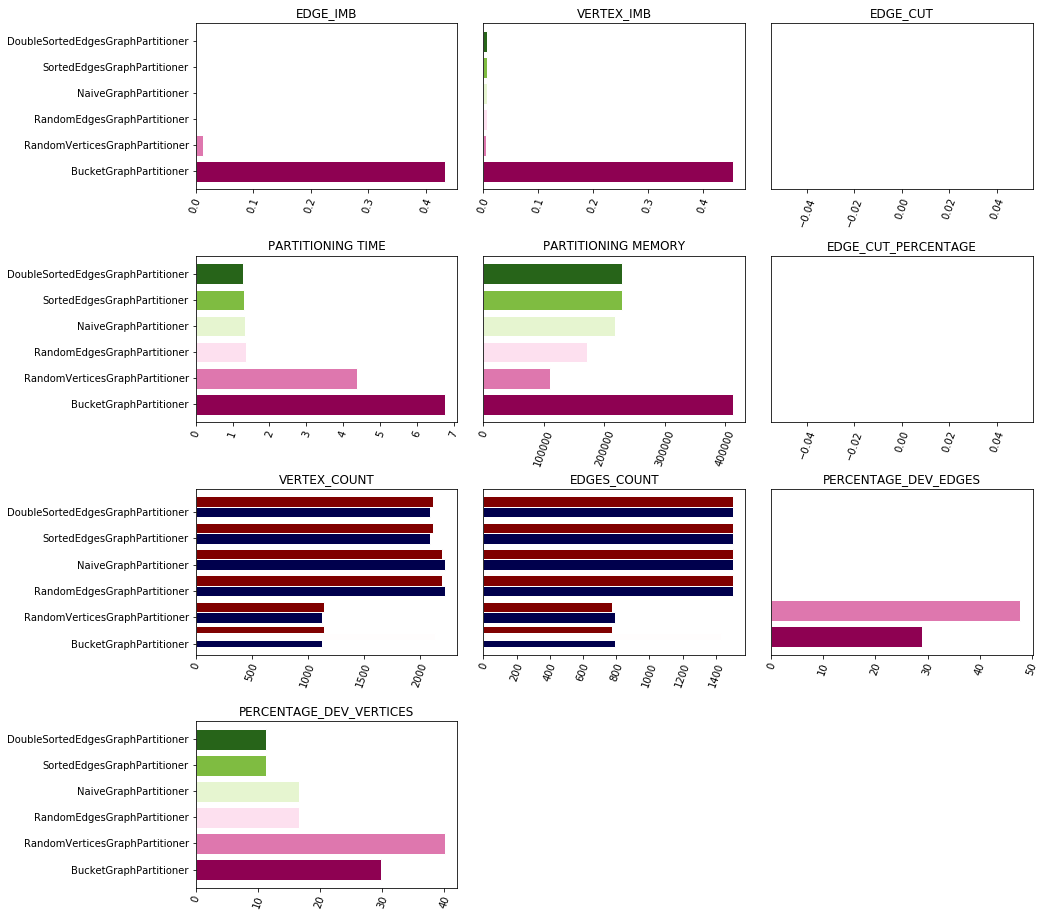

In [3]:
reports = {}
n_buckets = 3
n_partitions = get_number_of_partitions(n_buckets)
for dataset in data:
    print("----------------------------------------------------")
    dat = dataset()
    sample = dat["train"][:3000] # using only a subset for time (but time should be at least 1sec for each otherwise files are overlapping)
    data = GraphDataLoader(sample, backend=SQLiteAdapter, in_memory=False)
    print("Dataset: {} with {} triples".format(dataset.__name__, len(sample)))
    partitioners = [PARTITION_ALGO_REGISTRY.get(partitioner) for partitioner in list(PARTITION_ALGO_REGISTRY.keys())]
    report = compare_partitionings(partitioners, data)
    reports[dataset.__name__] = report
 
    with open('partitioning_results_ampligraph_baseline_dataloader_{}.json'.format(datetime.now().strftime("%d-%m-%Y_%I-%M-%S_%p")), 'w') as fp:
        json.dump(reports, fp)
    
    del dat

<a id='partition_data'></a>
### Accessing Original Data Through Partition

In below cell we can see how to access parent of partition data loader object and also how to access metadata of this partitioning.
Parent is just a reference to the object provided to the partitioner, it should be initialised with SQLite backend, metadata contains references to shelves with mappings and also the name of partition that can contain partitioning specific data like buckets in Bucket partitioner.

In [2]:
data = './fb15k/test.txt'
data = GraphDataLoader(data, batch_size=1, dataset_type="test", backend=SQLiteAdapter, in_memory=False)
partitioner = BucketGraphPartitioner(data, k=2)
for partition in partitioner:
    print(partition.parent)
    print(partition.metadata)

_split: memory before: 896.0Bytes, after: 3.2599MB, consumed: 3.2591MB; exec time: 131.21s
{'entities_shelf': '/tmp/entities_partition_0_buckets_0-0_06-08-2020_05-42-42_PM.shf', 'reversed_entities_shelf': '/tmp/reversed_entities_partition_0_buckets_0-0_06-08-2020_05-42-42_PM.shf', 'relations': '/tmp/relations_partition_0_buckets_0-0_06-08-2020_05-42-42_PM.shf', 'reversed_relations_dict': '/tmp/reversed_relations_partition_0_buckets_0-0_06-08-2020_05-42-42_PM.shf', 'name': 'partition_0_buckets_0-0'}
{'entities_shelf': '/tmp/entities_partition_1_buckets_0-1_06-08-2020_05-43-25_PM.shf', 'reversed_entities_shelf': '/tmp/reversed_entities_partition_1_buckets_0-1_06-08-2020_05-43-25_PM.shf', 'relations': '/tmp/relations_partition_1_buckets_0-1_06-08-2020_05-43-25_PM.shf', 'reversed_relations_dict': '/tmp/reversed_relations_partition_1_buckets_0-1_06-08-2020_05-43-25_PM.shf', 'name': 'partition_1_buckets_0-1'}
{'entities_shelf': '/tmp/entities_partition_2_buckets_1-1_06-08-2020_05-44-09_PM.sh

<a id='recover'></a>
#### Recovering original raw data from partition

In [3]:
import shelve
partitions = partitioner.get_partitions_list()
for partition in partitions:
    for batch in partition:
        print("Batch index in partition indexing: ", batch)    
        parent = partition.backend.mapper.get_indexes(batch, order="ind2raw")
        print("Batch index in parent indexing: ", parent)
        raw = partition.parent.backend.mapper.get_indexes(parent, order="ind2raw")
        print("Batch as a raw data: ", raw)        
        break
    break

Batch index in partition indexing:  [[   1  452 2565]]
Batch index in parent indexing:  [['1' '575' '2751']]
Batch as a raw data:  [['/m/083p7'
  '/government/political_appointer/appointees./government/government_position_held/office_holder'
  '/m/07hyk']]
